<h1>Regression Problem K-FOLD Cross validation</h1>

Cross-Validation R² Scores: [0.8741852630879081, 0.8954140497660077, 0.8774158148197667, 0.8880681258580765, 0.8869395877151997]
Average CV R²: 0.8844045682493917
Cross-Validation RMSE Scores: [np.float64(74022.8400614408), np.float64(58474.99320594515), np.float64(64649.82268446682), np.float64(60163.98887006693), np.float64(63228.65609431588)]
Average CV RMSE: 64108.06018324712

Train R²: 0.9621, Train RMSE: 36767.70
Test R²: 0.8730, Test RMSE: 65604.76
✅ Model is well-balanced (no strong overfitting/underfitting).


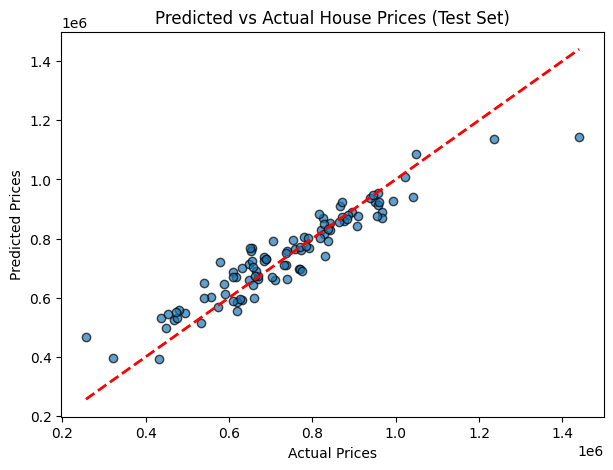

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1. Generate synthetic dataset (House Prices)
np.random.seed(42)
n_samples = 500

size = np.random.normal(150, 50, n_samples)          # house size (m²)
rooms = np.random.randint(2, 8, n_samples)           # number of rooms
age = np.random.randint(1, 50, n_samples)            # house age (years)
location = np.random.randint(1, 10, n_samples)       # location score 1-10

price = (size * 3000) + (rooms * 50000) - (age * 1000) \
        + (location * 20000) + np.random.normal(0, 50000, n_samples)

df = pd.DataFrame({"Size": size, "Rooms": rooms, "Age": age, "Location": location, "Price": price})

X = df.drop("Price", axis=1)
y = df["Price"]

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Random Forest with regularization (to avoid overfitting)
best_rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)

# 4. Cross-validation (manual loop for RMSE + R² per fold)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores = []
rmse_scores = []

for train_idx, val_idx in cv.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    best_rf.fit(X_tr, y_tr)
    y_val_pred = best_rf.predict(X_val)

    r2_scores.append(r2_score(y_val, y_val_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_val, y_val_pred)))

print("Cross-Validation R² Scores:", r2_scores)
print("Average CV R²:", np.mean(r2_scores))
print("Cross-Validation RMSE Scores:", rmse_scores)
print("Average CV RMSE:", np.mean(rmse_scores))

# 5. Train final model on full training data
best_rf.fit(X_train, y_train)

# 6. Predictions
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

# Training metrics
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

# Testing metrics
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"\nTrain R²: {train_r2:.4f}, Train RMSE: {train_rmse:.2f}")
print(f"Test R²: {test_r2:.4f}, Test RMSE: {test_rmse:.2f}")

# Overfitting check
if train_r2 - test_r2 > 0.1:
    print("⚠️ Model is overfitting.")
elif train_r2 < 0.5 and test_r2 < 0.5:
    print("⚠️ Model is underfitting.")
else:
    print("✅ Model is well-balanced (no strong overfitting/underfitting).")

# 7. Visualization: Predicted vs Actual (Test set)
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_test_pred, alpha=0.7, edgecolors="k")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Predicted vs Actual House Prices (Test Set)")
plt.show()


<h1> Classification Problem k-fold cross validation</h1>

Dataset preview:
     size_sqft  num_bedrooms  num_bathrooms  age_years  location_score  \
0  2248.357077             3              3         17        3.007810   
1  1930.867849             1              3          9        1.508641   
2  2323.844269             2              4         27        1.930554   
3  2761.514928             2              1         10        4.883573   
4  1882.923313             4              1         32        3.069265   

  house_size  
0     Medium  
1     Medium  
2     Medium  
3      Large  
4     Medium  

Cross-Validation Accuracy per fold: [0.9225 0.9325 0.92   0.9175 0.9075]
Average CV Accuracy: 0.9200 ± 0.0081

Test Accuracy: 0.9250

Classification Report:
              precision    recall  f1-score   support

       Large       0.81      0.86      0.84        66
      Medium       0.94      0.96      0.95       473
       Small       0.91      0.69      0.79        61

    accuracy                           0.93       600
   macro avg      

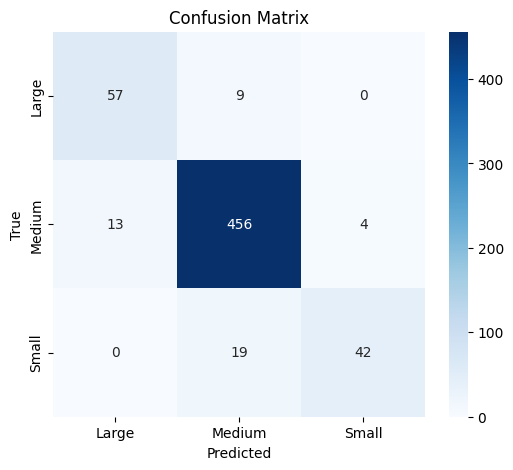

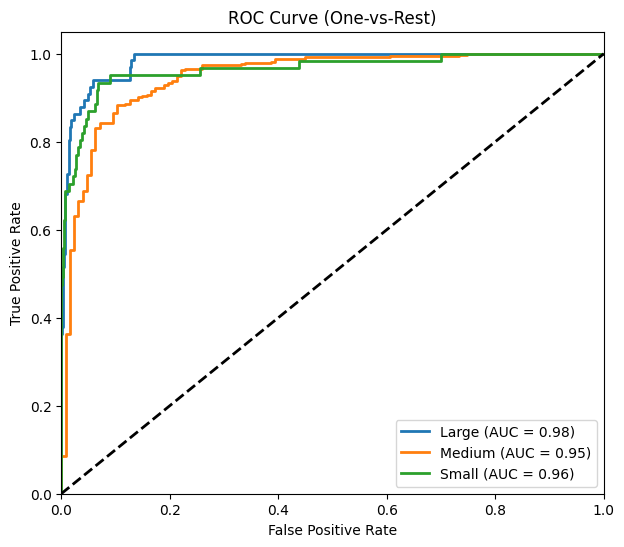

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import seaborn as sns

# --------------------------
# Generate synthetic dataset
# --------------------------
np.random.seed(42)
n_samples = 2000

# Features
size_sqft = np.random.normal(2000, 500, n_samples).clip(600, 4000)
num_bedrooms = np.random.choice([1, 2, 3, 4, 5], n_samples, p=[0.1, 0.25, 0.4, 0.2, 0.05])
num_bathrooms = np.random.choice([1, 2, 3, 4], n_samples, p=[0.2, 0.4, 0.3, 0.1])
age_years = np.random.randint(0, 50, n_samples)
location_score = np.random.uniform(1, 10, n_samples)

# Price formula
price = (
    size_sqft * 150 +
    num_bedrooms * 10000 +
    num_bathrooms * 7000 +
    (50 - age_years) * 1000 +
    location_score * 5000 +
    np.random.normal(0, 20000, n_samples)
)

# Categorize into classes
labels = []
for p in price:
    if p < 300000:
        labels.append("Small")
    elif p < 500000:
        labels.append("Medium")
    else:
        labels.append("Large")

# Create DataFrame
data = pd.DataFrame({
    'size_sqft': size_sqft,
    'num_bedrooms': num_bedrooms,
    'num_bathrooms': num_bathrooms,
    'age_years': age_years,
    'location_score': location_score,
    'house_size': labels
})

print("Dataset preview:")
print(data.head())

# --------------------------
# Features & target
# --------------------------
X = data.drop('house_size', axis=1)
y = data['house_size']

# --------------------------
# Define model (regularized to reduce overfitting)
# --------------------------
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)

# --------------------------
# Cross-validation
# --------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf, X, y, cv=cv, scoring="accuracy")

print("\nCross-Validation Accuracy per fold:", cv_scores)
print(f"Average CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# --------------------------
# Train-test split (for final check)
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

test_acc = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {test_acc:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# --------------------------
# Confusion Matrix
# --------------------------
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# --------------------------
# ROC Curve
# --------------------------
y_test_bin = label_binarize(y_test, classes=rf.classes_)
y_score = rf.predict_proba(X_test)
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(7, 6))
for i, class_name in enumerate(rf.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{class_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest)")
plt.legend(loc="lower right")
plt.show()
